This notebook covers the code for exploratory analysis of the data

## Problem Statement

Given a User U and edit history (e1,e2,e3....eN) and provided that eN has been reverted we need to predict if the User is going to make an edit e(N+1)

We aim to categorize data by user_id,article_id pairs. Since, the time at which user received a revert is not noted it cannot be said with certainity that a user stopped editing after receiving a revert since, a revert can come long after the user stopped using the platform altogether.

Therefore, it is better to focus on the user_id,article_id pairs. We focus on the article_id on which the user gets a revert, and focus on predicting whether a user comes back to provide an edit on that particula article.

If the test_data contains a mix of article_id we will focus on the article_id which got the revert.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('../data/wikichallenge/training.tsv', sep='\t', header=0)

In [3]:
print(train_data.columns)
print(train_data.shape)
print(train_data.dtypes)
train_data.head(n=10)

Index(['user_id', 'article_id', 'revision_id', 'namespace', 'timestamp', 'md5',
       'reverted', 'reverted_user_id', 'reverted_revision_id', 'delta',
       'cur_size'],
      dtype='object')
(22126031, 11)
user_id                  int64
article_id               int64
revision_id              int64
namespace                int64
timestamp               object
md5                     object
reverted                 int64
reverted_user_id         int64
reverted_revision_id     int64
delta                    int64
cur_size                 int64
dtype: object


,user_id,article_id,revision_id,namespace,timestamp,md5,reverted,reverted_user_id,reverted_revision_id,delta,cur_size
0,389427,9445560,279555872,0,2009-03-25 10:31:33,175d8a73b80b3c95719c458b698e5179,0,-1,-1,276,1661
1,389427,9445560,279556938,0,2009-03-25 10:41:09,48fa53402b2819283472a899a30117a1,0,-1,-1,97,1758
2,389427,9445560,304562912,0,2009-07-27 22:23:46,28b4e603c11f65343c39fb2946615925,0,-1,-1,18,1776
3,389427,9445560,304563043,0,2009-07-27 22:24:41,cac360b626a79d08f7369d59b7d6c475,0,-1,-1,4,1780
4,389427,9445560,346862274,0,2010-02-28 11:23:52,1524d65e5ffb54be4cf2fee045b8a414,0,-1,-1,-11,2227
5,389427,864287,14648017,0,2005-06-03 17:05:34,6299ecddbffd72e06151bc5d1e0c681b,0,-1,-1,111,368
6,389427,864287,14648035,0,2005-06-03 17:42:23,dff7fe4ba8cb69c932eb61301b8ca0e0,0,-1,-1,8,376
7,389427,864287,14648632,0,2005-06-03 17:42:55,29f7f382ad0213dbedad8e98d5600b00,0,-1,-1,-6,370
8,389427,864287,14666943,0,2005-06-03 17:54:59,05305e089c89f9a0e70f5991afe554be,0,-1,-1,23,393
9,870433,4205653,41325786,0,2006-02-26 16:25:02,5b61e2966288555ba1e7fe1b74377933,0,-1,-1,28,2642


In [4]:
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])

|
| 
The _reverted_ column is the indicator if the edit was reverted. We can see how many reverts are there in the training data. 

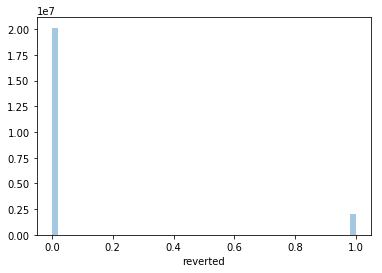

In [5]:
sns.distplot(train_data['reverted'],kde=False)

||
The ratio of reverts to edits is roughly 12.5% 

The next thing to check is the number of unique users with reverted flag as **True** . i.e. How many unique users' edits have been reverted

First we need to create a dataset from the train_data with all the edits of (users,article) which have a revert. This will shorten the processing time.


In [6]:
grouped = train_data.loc[train_data.index[train_data['reverted'] == 1]].groupby(['user_id','article_id'])

user_article_group = set()

for name,entry in grouped:
    user_article_group.add((name[0],name[1]))
user_article_group = list(user_article_group)


indices = train_data[['user_id', 'article_id']].apply(tuple, axis=1).isin(user_article_group)

train_df = train_data[np.array(indices).astype(bool)]

del train_data, indices, grouped, user_article_group

train_df.sort_values(by=['user_id','article_id','timestamp'],inplace=True)

We move on to see how many reverts have a followup edit from the user.


In [7]:
train_df = train_df.reset_index(drop=True)
train_df.head()
train_df.describe()

,user_id,article_id,revision_id,namespace,reverted,reverted_user_id,reverted_revision_id,delta,cur_size
count,6.956193e+06,6.956193e+06,6.956193e+06,6.956193e+06,6.956193e+06,6.956193e+06,6.956193e+06,6.956193e+06,6.956193e+06
mean,5.044872e+05,6.648108e+06,2.075045e+08,6.733101e-01,2.859695e-01,1.442268e+05,6.044301e+07,6.313725e+01,2.953543e+04
std,2.897644e+05,7.904562e+06,1.081622e+08,1.281863e+00,4.518750e-01,2.737851e+05,1.105537e+08,7.687331e+03,4.629356e+04
min,6.000000e+01,1.200000e+01,3.700000e+01,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-3.750626e+06,0.000000e+00
25%,2.548810e+05,3.769400e+05,1.180573e+08,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,4.627000e+03
50%,5.000760e+05,2.870578e+06,2.138962e+08,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,1.415900e+04
75%,7.540610e+05,1.106403e+07,3.018403e+08,1.000000e+00,1.000000e+00,1.336240e+05,7.502302e+07,1.000000e+02,3.631400e+04
max,9.999980e+05,3.048189e+07,4.074148e+08,5.000000e+00,1.000000e+00,9.999980e+05,4.018891e+08,1.935126e+06,1.935358e+06


In [8]:
train_df.head()

,user_id,article_id,revision_id,namespace,timestamp,md5,reverted,reverted_user_id,reverted_revision_id,delta,cur_size
0,60,19728,325096063,0,2009-11-10 19:12:56,8ce49ff3ca8ff94c04d8a68c4c0f697c,0,-1,-1,2,80731
1,60,19728,325097673,0,2009-11-10 19:21:18,8ce49ff3ca8ff94c04d8a68c4c0f697c,1,60,325096063,2,80731
2,60,19728,325099072,0,2009-11-10 19:28:03,8ce49ff3ca8ff94c04d8a68c4c0f697c,1,60,325096063,2,80731
3,60,19728,325099940,0,2009-11-10 19:32:25,403a2f255af2cac3eb7b55134945932e,0,-1,-1,14,80743
4,60,19728,325104819,0,2009-11-10 19:57:04,c9cedf1e4f55538465ac5c5078d4deeb,0,-1,-1,20,80749


C:\Users\Aditya\Anaconda3\envs\Keras\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\Aditya\Anaconda3\envs\Keras\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
C:\Users\Aditya\Anaconda3\envs\Keras\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
C:\Users\Aditya\Anaconda3\envs\Keras\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


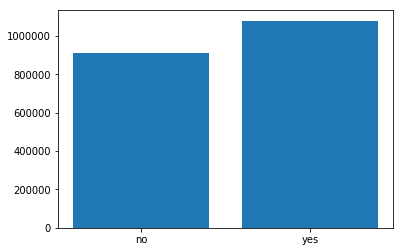

In [9]:
reverts = train_df.index[train_df['reverted'] == 1].tolist()
counts = {'yes':0,'no':0}
#We count the instances where the edit was reverted and the followup edit was there or not


for row in reverts:
    
    u_id = train_df.get_value(row,'user_id')
    a_id = train_df.get_value(row,'article_id')
    
    try:
        next_u_id = train_df.get_value(row+1,'user_id')
        next_a_id = train_df.get_value(row+1,'article_id')
    except:
        counts['no'] += 1
        break
    
    if u_id == next_u_id and a_id == next_a_id:
        counts['yes'] += 1
    else:
        counts['no'] += 1


plt.bar([0,1],[counts['no'],counts['yes']])
plt.xticks([0,1],('no','yes'))   
plt.show()

del reverts

There seems to be a balanced data around the prediction we want to make.

The assumption we made is that if there doesn't exist an edit after a revert the user didnt redit his post. However, this can also be due to the fact that the timeframe in which data was collected could be too short and the user returned at some point after the data was collected. But for this work we shall work with the assumption that if the user didn't edit in the dat we have, the edit after a revert was **NOT** made
It seems lot of reverts have a follow-up edit.

We can try and see if there is a trend for edit after a revert if a user made a number of edits previously. i.e. given user has devoted time to the article(number of edits), how many of them provide an edit after a revert. 

In [10]:
counts = []
# To speed-up row access we use numpy
proxy = train_df.to_numpy()

rows,cols = proxy.shape

cnt = 0

for row in range(rows):
    u_id = proxy[row][0]
    a_id = proxy[row][1]
    is_revert = proxy[row][6]
    cnt+=1
    try:
        if is_revert or u_id != proxy[row+1][0] or a_id != proxy[row+1][1]:
            counts.append(cnt)
            cnt = 0
    except:
        counts.append(cnt)
        break
        
del proxy

In [11]:
print(max(counts))

2447


In [12]:
reverts = train_df.index[train_df['reverted'] == 1].tolist()
revert_action = {'yes':[],'no':[]}
#We visualize a 1-D plot for the number of edits colored by if there was a follow up edit or not

# To speed-up row access we use numpy
proxy = train_df.to_numpy()

for row in reverts:
    u_id = proxy[row][0]
    a_id = proxy[row][1]
    
    try:
        next_u_id = proxy[row+1][0]
        next_a_id = proxy[row+1][1]
    except:
        revert_action['no'].append(cnt_edits)
        break
    
    prev_u_id = proxy[row-1][0]
    prev_a_id = proxy[row-1][1]
    prev_revert = proxy[row-1][6]
    
    cnt_edits = 1
    r = row-1
    while prev_u_id == u_id and prev_a_id == a_id and prev_revert == 0:
        cnt_edits += 1
        r-=1
        if r < 0:
            break
        prev_u_id = proxy[r-1][0]
        prev_a_id = proxy[r-1][1]
        prev_revert = proxy[r-1][6]
        
    
    if u_id == next_u_id and a_id == next_a_id:
        revert_action['yes'].append(cnt_edits)
    else:
        revert_action['no'].append(cnt_edits)

del proxy,reverts

In [13]:
print(max(revert_action['yes']))
print(max(revert_action['no']))

2188
715


The number is different from the max we computed earlier. It is due to the fact that earlier we considered the longest continuous chain of user_id,article_id until a revert was met. It can also be possible to see such a chain after a revert.

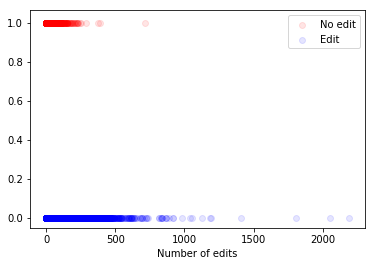

In [14]:
plt.scatter(revert_action['no'],[1]*len(revert_action['no']),alpha=0.1,label='No edit',c='r')
plt.xlabel('Number of edits') 
plt.scatter(revert_action['yes'],[0]*len(revert_action['yes']),alpha=0.1,label='Edit',c='b')
plt.legend()
plt.show()

del revert_action

We can see that if the number of edits made by the user before the revert is above a threshold for example 300 it's safe to say the user will provide a subsequent edit after a revert. However, it doesn't tell much. A user can make a lot of insignificant edits so we can make use of **cur_size** field which can provide an alternate way of viewing the data

Most likely interpretation of the field **cur_size** is that it tells the size of the article after an edit(probably in bytes). However, to process the train_data is very time consuming to obtain the **cur_size** field of the article prior to the edit which got reverted. We can approximate the change in **cur_size** field by using the **cur_size** field of the previous edit of the user. Incase, there was no previous edit by the user to an article before a revert the change in **cur_size** is defaulted to 0.  

In [15]:
reverts = train_df.index[train_df['reverted'] == 1].tolist()
revert_action = {'yes':[],'no':[]}
#We visualize a 1-D plot for the number of edits colored by if there was a follow up edit or not

# To speed-up row access we use numpy
proxy = train_df.to_numpy()

for row in reverts:
    u_id = proxy[row][0]
    a_id = proxy[row][1]
    
    try:
        prev_u_id = proxy[row-1][0]
        prev_a_id = proxy[row-1][1]
        if prev_u_id == u_id and prev_a_id == a_id:
            sz = abs(proxy[row][10] - proxy[row-1][10])
        else:
            sz = 0
    except:
        sz = 0
        
    try:
        next_u_id = proxy[row+1][0]
        next_a_id = proxy[row+1][1]
    except:
        revert_action['no'].append(sz)
        break
    
    
    if u_id == next_u_id and a_id == next_a_id:
        revert_action['yes'].append(sz)
    else:
        revert_action['no'].append(sz)

del proxy,reverts


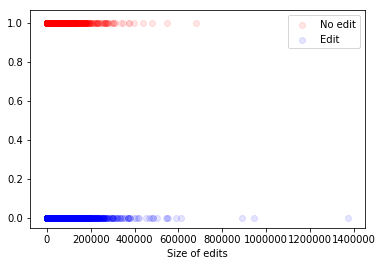

In [16]:
plt.scatter(revert_action['no'],[1]*len(revert_action['no']),alpha=0.1,label='No edit',c='r')
plt.xlabel('Size of edits') 
plt.scatter(revert_action['yes'],[0]*len(revert_action['yes']),alpha=0.1,label='Edit',c='b')
plt.legend()
plt.show()

In [17]:
del revert_action

The **cur_size** field has not provided us with helpful insights. Might be due to the fact that we approximated the change in **cur_size**. 
#### TODO: Exact Cur_Size

let's check if the identity of the person who makes the revert matters. Specifically, if a person reverting is different from the user do we see mroe edits after a revert to the case when the reverter is different.

In [18]:
reverts = train_df.index[train_df['reverted'] == 1].tolist()
revert_action = {'same':[0,0],'different':[0,0]}


# To speed-up row access we use numpy
proxy = train_df.to_numpy()

for row in reverts:
    u_id = proxy[row][0]
    a_id = proxy[row][1]
    
    is_same = proxy[row][7] == u_id
    
    try:
        next_u_id = proxy[row+1][0]
        next_a_id = proxy[row+1][1]
    except:
        if is_same:
            revert_action['same'][0] += 1
        else:
            revert_action['different'][0] += 1
        break
        
    if u_id == next_u_id and a_id == next_a_id:
        if is_same:
            revert_action['same'][1] += 1
        else:
            revert_action['different'][1] += 1
    else:
        if is_same:
            revert_action['same'][0] += 1
        else:
            revert_action['different'][0] += 1

del proxy,reverts

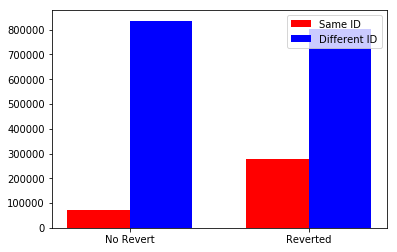

{'same': [73187, 277473], 'different': [836286, 802313]}


In [19]:
width = 0.35 
ind = np.arange(2) 
fig, ax = plt.subplots()
ax.bar(ind,revert_action['same'],width,label='Same ID',color='r')
ax.bar(ind+width,revert_action['different'],width,label='Different ID',color='b')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('No Revert','Reverted'))
ax.legend()
plt.show()

print(revert_action)
del revert_action

As expected, users who revert their changes are quite likely to make an edit after the revert. 
This says that the reverter's ID is of relevance for the prupose of prediction

Lets move to the **namespace** field. It identifies the category of the article.

In [20]:
namespaces = pd.read_csv('../data/wikichallenge/namespaces.tsv', sep='\t', header=0)
namespaces.values

array([[0, 'Main'],
       [1, 'Talk'],
       [2, 'User'],
       [3, 'User Talk'],
       [4, 'Wikipedia'],
       [5, 'Wikipedia Talk']], dtype=object)

We try to observe the behaviour specific to the namespace of articles

In [21]:
reverts = train_df.index[train_df['reverted'] == 1].tolist()
revert_action = {0:[0,0],1:[0,0],2:[0,0],3:[0,0],4:[0,0],5:[0,0]}

proxy = train_df.to_numpy()

for row in reverts:
    u_id = proxy[row][0]
    a_id = proxy[row][1]
    namespace = proxy[row][3]
    
    try:
        next_u_id = proxy[row+1][0]
        next_a_id = proxy[row+1][1]
    except:
        revert_action[namespace][0] += 1
        break
    
    if u_id == next_u_id and a_id == next_a_id:
        revert_action[namespace][1] += 1
    else:
        revert_action[namespace][0] += 1
    
        
del proxy,reverts

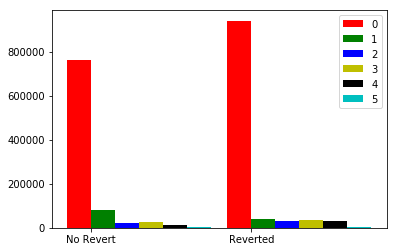

{0: [764323, 941050], 1: [80929, 38984], 2: [21875, 31002], 3: [27355, 36189], 4: [12972, 29403], 5: [2019, 3158]}


In [22]:
width = 0.15 
ind = np.arange(2) 
fig, ax = plt.subplots()
mult = 0
col = ['r','g','b','y','k','c']
for key, value in revert_action.items():
    ax.bar(ind+mult*width,value,width,label=key,color=col[mult])
    mult+=1
    
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('No Revert','Reverted'))
ax.legend()
plt.show()

print(revert_action)
del revert_action

It seems articls with namespace **1** has a dip in the number of edits following a revert

Let's see if we can find some sense in the comments related to a revert.

In [23]:
comments = pd.read_csv('../data/wikichallenge/comments.tsv', sep='\t', header=0)
comments.head()

,revision_id,comment
0,198862276,"/* ""I doubt Will would pick on some random new..."
1,123682893,/* Question to anyone watching... */ reply to ...
2,154648658,Replacing [[Image:Flag_of_USA.svg]] with [[Ima...
3,356106332,capt. to captain
4,108137146,rm deleted image


### Merge Comments

We prepare a single dataframe on which we can perform feature analysis. This will require us to merge comments, titles etc. into the train_df

In [24]:
comments = pd.read_csv('../data/wikichallenge/comments.tsv', sep='\t', header=0)
train_df = pd.merge(train_df,comments,on='revision_id',how='left')
del comments

In [25]:
train_df.head(n=5)

,user_id,article_id,revision_id,namespace,timestamp,md5,reverted,reverted_user_id,reverted_revision_id,delta,cur_size,comment
0,60,19728,325096063,0,2009-11-10 19:12:56,8ce49ff3ca8ff94c04d8a68c4c0f697c,0,-1,-1,2,80731,NaN
1,60,19728,325097673,0,2009-11-10 19:21:18,8ce49ff3ca8ff94c04d8a68c4c0f697c,1,60,325096063,2,80731,"I know what you are saying, but see my comment..."
2,60,19728,325099072,0,2009-11-10 19:28:03,8ce49ff3ca8ff94c04d8a68c4c0f697c,1,60,325096063,2,80731,Please see the discussion forum before you rev...
3,60,19728,325099940,0,2009-11-10 19:32:25,403a2f255af2cac3eb7b55134945932e,0,-1,-1,14,80743,NaN
4,60,19728,325104819,0,2009-11-10 19:57:04,c9cedf1e4f55538465ac5c5078d4deeb,0,-1,-1,20,80749,NaN


In [26]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import preprocess_string

reverts = train_df.index[train_df['reverted'] == 1].tolist()

edit_words = {}
no_edit_words = {}

proxy = train_df.to_numpy()

for row in reverts:
    
    u_id = proxy[row][0]
    a_id = proxy[row][1]
    
    words = str(proxy[row][11])
    no_stop_words = remove_stopwords(words)
    processed_words = preprocess_string(no_stop_words)
    
    try:
        next_u_id = proxy[row+1][0]
        next_a_id = proxy[row+1][1]
    except:
        for word in processed_words:
            if word not in no_edit_words:
                no_edit_words[word] = 0
            no_edit_words[word] += 1
        break
    
    if u_id == next_u_id and a_id == next_a_id:
        for word in processed_words:
            if word not in edit_words:
                edit_words[word] = 0
            edit_words[word] += 1
    else:
        for word in processed_words:
            if word not in no_edit_words:
                no_edit_words[word] = 0
            no_edit_words[word] += 1
        
del proxy, reverts

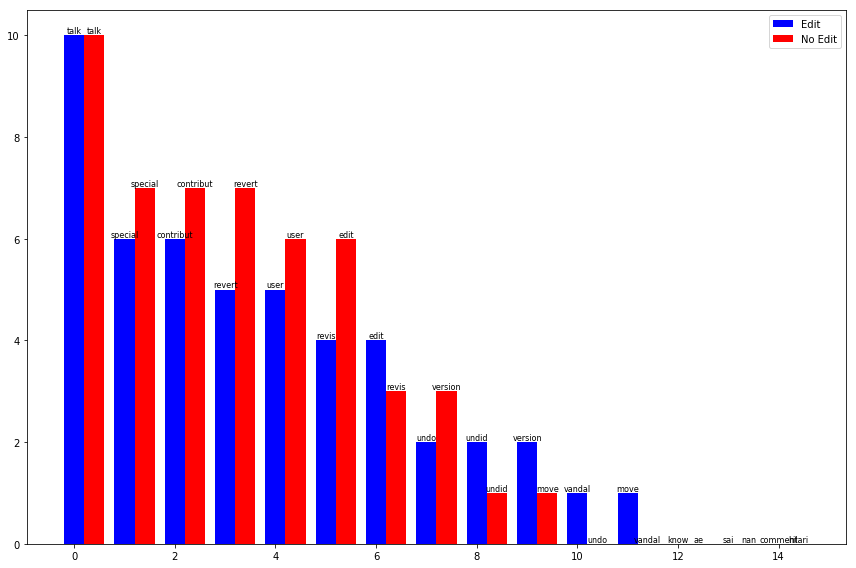

In [27]:
from collections import Counter

no_edit_counts = Counter(no_edit_words)
total = sum(no_edit_counts.values(), 0.0)
for key in no_edit_counts:
    no_edit_counts[key] = int(100*no_edit_counts[key]/total)

edit_counts = Counter(edit_words)
total = sum(edit_counts.values(), 0.0)
for key in edit_counts:
    edit_counts[key] = int(100*edit_counts[key]/total)

freq_no_edits = no_edit_counts.most_common(15)
freq_edits = edit_counts.most_common(15)

edits_text = [i[1] for i in freq_edits]
no_edits_text = [i[1] for i in freq_no_edits]

width = 0.4
ind = np.arange(len(freq_edits)) 
fig, ax = plt.subplots(figsize=(12,8))
bar_edit = ax.bar(ind,edits_text,width,label='Edit',color='b')
bar_no_edit = ax.bar(ind+width,no_edits_text,width,label='No Edit',color='r')

cnt = 0
for rect in bar_edit:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, freq_edits[cnt][0], ha='center', va='bottom',fontsize=8)
    cnt += 1

cnt = 0
for rect in bar_no_edit:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, freq_no_edits[cnt][0], ha='center', va='bottom',fontsize=8)
    cnt += 1
    

ax.legend()
plt.tight_layout()
plt.show()

From the initial glance the comments don't look much helpful. Plus, the comments seem to be only initial few words rather than the complete comment. For the task of prediction we will ignore the comments field

In [28]:
del no_edit_words, edit_words, edit_counts, no_edit_counts

### Dataset Creation

We now create the dataset which we can train using only the important columns and some modifications

1. We will be storing the number of edits prior to the reverted edit
2. One hot encoding for namespace
3. Boolean if the reverter is same as the editor


In [ ]:
train_df.drop('comment',inplace=True,axis=1)

In [32]:

reverts = train_df.index[train_df['reverted'] == 1].tolist()
proxy = train_df.to_numpy()

data = []

for row in reverts:
    u_id = proxy[row][0]
    a_id = proxy[row][1]
    namespace = proxy[row][3]
    
    is_reverter = u_id == proxy[row][7]
    try:
        next_u_id = proxy[row+1][0]
        next_a_id = proxy[row+1][1]
    except:
        data.append([cnt_edits,namespace,is_reverter,0])
    
    prev_u_id = proxy[row-1][0]
    prev_a_id = proxy[row-1][1]
    prev_revert = proxy[row-1][6]
    
    cnt_edits = 0
    r = row-1
    while prev_u_id == u_id and prev_a_id == a_id and prev_revert == 0:
        cnt_edits += 1
        r-=1
        if r < 0:
            break
        prev_u_id = proxy[r-1][0]
        prev_a_id = proxy[r-1][1]
        prev_revert = proxy[r-1][6]
    
    
    if u_id == next_u_id and a_id == next_a_id:
        data.append([cnt_edits,namespace,is_reverter,1])
    else:
        data.append([cnt_edits,namespace,is_reverter,0])

del proxy, reverts

In [34]:
dataset = pd.DataFrame(data,columns=['number_of_prev_edits','namespace','is_reverter','target'])
dataset.to_csv('../data/dataset.csv')

In [35]:
dataset.head()

,number_of_prev_edits,namespace,is_reverter,target
0,1,0,True,1
1,0,0,True,1
2,1,3,True,1
3,1,0,True,1
4,1,0,False,1


In [36]:
dataset.describe()

,number_of_prev_edits,namespace,target
count,1.989260e+06,1.989260e+06,1.989260e+06
mean,1.881828e+00,3.074932e-01,5.428084e-01
std,1.130274e+01,8.748928e-01,4.981642e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.000000e+00,0.000000e+00,1.000000e+00
max,2.187000e+03,5.000000e+00,1.000000e+00


In [37]:
dataset.shape

(1989260, 4)